In [1]:
using PyPlot
using Distributions

include("utils.jl")
include("ode.jl")

srand(42);

In [3]:
function SequentialMonteCarlo(X₀, p, γ; μ=0.1)
    # initialization
    N,d = size(X₀)
    w = MvNormal(μ^2 * eye(d))

    X = X₀
    W = ones(N)/N
    Wₙ = SharedArray{Float64}(N)
    
    
    # sampling
    for n = 1:p
        X += rand(w, N)'
        
        # resampling
        if 1 / vecdot(W,W) < N/2
            X = X[rand(Categorical(W), N), :]
            W = ones(N)/N
        end

        @sync @parallel for i=1:N
            Wₙ[i] = γ(n, X[i,:])
        end
        #Wₙ = [ γ(n, X[i,:]) for i in 1:N]    
        W = W.*Wₙ / vecdot(W, Wₙ)
    end
    
    W,X
end

SequentialMonteCarlo (generic function with 1 method)

In [4]:
function simulate(n, g, b; Θ₀ = 5*pi/180, l = 7.4, τ = 0.01)
    n_times = 0
    times = zeros(n)

    t = 0
    Θ = [Θ₀, 0]
    
    function dΘ(Θ)
        [Θ[2], -(Θ[2]*b + g*sin(Θ[1])/l)]
    end
    
    while n_times < n
        Θₙ = rk4(dΘ, Θ, τ)
        
        # if the angle has changed sign, we linearly approximate the intersection
        # with 0
        if Θ[1] * Θₙ[1] <= 0
            t_intersect = t - τ*Θ[1]/(Θₙ[1] - Θ[1])
            n_times += 1
            times[n_times] = t_intersect
        end
        
        Θ = Θₙ
        t += τ
    end
    
    times
end

simulate (generic function with 1 method)

In [5]:
measurements = open(readdlm,"../data/original_data")
measurements_mask = abs(sign(measurements))

n_measurements = size(measurements)[1]
max_intersects = size(measurements)[2]

prior = dunif(5, 15)

likelihood = m ->
    let
        d = dnorm(0, 1)
        t = simulate(max_intersects, m[1], 0.4, τ=0.1)
        exp(sumoveri(i -> sum(log.(d.(measurements_mask[i,:] .* (measurements[i,:] - t)))), n_measurements))
    end

unnormalized_posterior = m ->
    let
        p = prior(m[1])
        p > 0 ? p*likelihood(m) : 0
    end

#samples, n_accepted = MetropolisHastings(10000, unnormalized_posterior, 0.1, rand(1)*10 + 5)

(::#26) (generic function with 1 method)

In [6]:
τs = [1 0.5 0.1 0.05 0.01]

likelihood₁ = (n, m) ->
    let
        d = dnorm(0, 1)
        t = simulate(max_intersects, m[1], 0.4, τ=τs[n])    
        exp(sumoveri(i -> sum(log.(d.(measurements_mask[i,:] .* (measurements[i,:] - t)))), n_measurements))
    end

W,X = SequentialMonteCarlo(rand(1000,1)*10+5, length(τs), likelihood₁)

vecdot(W,X)

LoadError: On worker 2:
UndefVarError: dnorm not defined
 in #28 at ./In[6]:5
 in macro expansion at ./In[3]:22 [inlined]
 in #15 at ./multi.jl:2039
 in #691 at ./multi.jl:1904
 in #642 at ./multi.jl:1417
 in run_work_thunk at ./multi.jl:1001
 in run_work_thunk at ./multi.jl:1010 [inlined]
 in #617 at ./event.jl:68

In [ ]:
progress = (W, X) ->
    let
        
        Y = round.(X*10)
        mini = minimum(Y)
        n = convert(Int32,maximum(Y) - mini + 1)
        ws = zeros(n)
        
        for i=1:1000
            ws[convert(Int32,Y[i]-mini+1)]+=W[i]
        end

        clf()
        
        ylim(0,maximum(W)*1.1)
        xlim(5,15)
        scatter(X, W, s=1, alpha=0.8)
        
        sleep(0.5)
        
    end

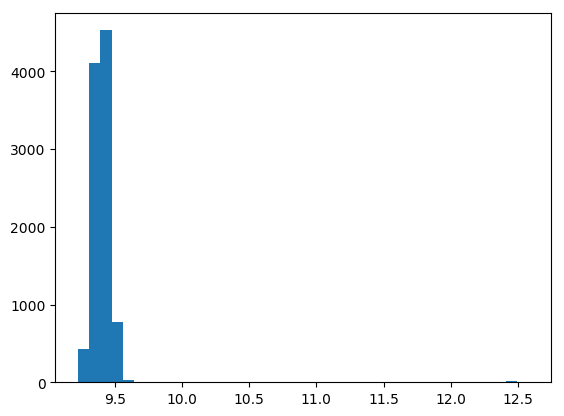

9.422434147250133

In [88]:
PyPlot.plt[:hist](samples[:,1], 40);
mean(samples[:,1])

In [12]:
function MetropolisHastings(K, Π, γ, x₀)
    X = zeros(K, length(x₀))
    w = MvNormal(γ^2*eye(length(x₀)))
    x = x₀
    πₓ = Π(x)
    accepted = 0
    for k=1:K
        y = x + rand(w)
        πₙ = Π(y)
        if rand() < min(1, πₙ / πₓ)
            x = y
            πₓ = πₙ
            accepted += 1
        end
        X[k,:] = x
    end
    X, accepted
end;